# Recommender Systems

In [ ]:
from random import gauss as gs, uniform as uni, seed
import numpy as np
import pandas as pd

![Netflix](https://miro.medium.com/max/1400/1*jlQxemlP9Yim_rWTqlCFDQ.png)

![Amazon](http://rejoiner.com/resources/wp-content/uploads/2016/06/recommended-thomas.png)

## Agenda

SWBAT:

- describe the difference between content-based and collaborative-filtering algorithms;
- explain and use the cosine similarity metric;
- describe the algorithm of alternating least-squares.

## Intro

Recommender systems can be classified along various lines. One fundamental distinction is **content-based** vs. **collaborative-filtering** systems.

To illustrate this, consider two different strategies: (a) I recommend items to you that are *similar to other items* you've used/bought/read/watched; and (b) I recommend items to you that people *similar to you* have used/bought/read/watched. The first is the **content-based strategy**; the second is the **collaborative-filtering strategy**. 

Another distinction drawn is in whether (a) the system uses existing ratings to compute user-user or item-item similarity, or (b) the system uses machine learning techniques to make predictions. Recommenders of the first sort are called **memory-based**; recommenders of the second sort are called **model-based**.

## Content-Based Systems

The basic idea here is to recommend items to a user that are *similar to* items that the user has already enjoyed. Suppose we represent TV shows as rows, where the columns represent various features of these TV shows. These features might be things like the presence of a certain actor or the show fitting into a particular genre etc. We'll just use binary features here, perhaps the result of some one-hot encoding:

In [ ]:
tv_shows = np.array([[0, 1, 1, 0, 1, 1, 1],
                   [0, 0, 0, 1, 1, 1, 0],
                   [1, 1, 1, 0, 0, 1, 1],
                   [0, 1, 1, 1, 0, 0, 1]])

tv_shows

Bob likes the TV Show represented by Row \#1. Which show (row) should we recommend to Bob?

One natural way of measuring the similarity between two vectors is by the **cosine of the angle between them**. Two points near one another in feature space will correspond to vectors that nearly overlap, i.e. vectors that describe a small angle $\theta$. And as $\theta$ decreases, $\cos(\theta)$ *increases*. So we'll be looking for large values of the cosine (which ranges between -1 and 1). We can also think of the cosine between two vectors as the *projection of one vector onto the other*:

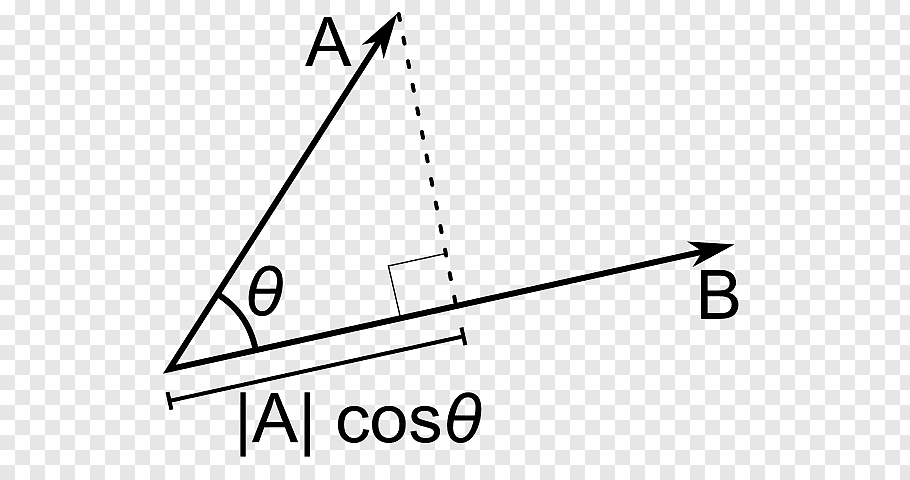

We can use this metric easily if we treat our rows (the items we're comparing for similarity) as vectors: We can calculate the cosine of the angle $\theta$ between two vectors $\vec{a}$ and $\vec{b}$ as follows: $\cos(\theta) = \frac{\vec{a}\cdot\vec{b}}{|\vec{a}||\vec{b}|}$

In [ ]:
numerators = np.array([tv_shows[0].dot(tv_show) for tv_show in tv_shows[1:]])
denominators = np.array([np.sqrt(sum(tv_shows[0]**2)) *\
                         np.sqrt(sum(tv_show**2)) for tv_show in tv_shows[1:]])

numerators / denominators

Since the cosine similarity to Row \#1 is highest for Row \#3, we would recommend this film.

***

## Collaborative Filtering

Now the idea is to recommend items to a user based on what *similar* users have enjoyed. Suppose we have the following recording of explicit ratings of five items by three users:

In [ ]:
users = np.array([[5, 4, 3, 4, 5], [3, 1, 1, 2, 5], [4, 2, 3, 1, 4]])

new_user = np.array([5, 0, 0, 0, 0])
users

To which user is `new_user` most similar?

One metric is cosine similarity:

In [ ]:
new_user_mag = 5

numerators = np.array([new_user.dot(user) for user in users])
denominators = np.array([new_user_mag * np.sqrt(sum(user**2))\
                         for user in users])

numerators / denominators

But we could also use another metric, such as Pearson Correlation:

In [ ]:
[np.corrcoef(new_user, user)[0, 1] for user in users]

For more on content-based vs. collaborative systems, see [this Wikipedia article](https://en.wikipedia.org/wiki/Collaborative_filtering) and [this blog post](https://towardsdatascience.com/recommendation-systems-models-and-evaluation-84944a84fb8e). [This post](https://dataconomy.com/2015/03/an-introduction-to-recommendation-engines/) on dataconomy is also useful.

***

## Matrix Factorization

Suppose we start with a matrix $R$ of users and products, where each cell records the ranking the relevant user gave to the relevant product. Very often we'll be able to record this data as a sparse matrix, because many users will not have ranked many items.

Imagine factoring this matrix into a user matrix $P$ and an item matrix $Q^T$: $R = PQ^T$. What would the shapes of $P$ and $Q^T$ be? Clearly $P$ must have as many rows as $R$, which is just the number of users who have given ratings. Similarly, $Q^T$ must have as many columns as $R$, which is just the number of items that have received ratings. We also know that the number of columns of $P$ must match the number of rows of $Q^T$ for the factorization to be possible, but this number could really be anything. In practice this will be a small number, and for reasons that will emerge shortly let's refer to these dimensions as **latent features** of the items in $R$. If $p$ is a row of $P$, i.e. a user-vector, and $q$ is a column of $Q^T$, i.e. an item-vector, then $p$ will record the user's particular weights or *preferences* with respect to the latent features, while $q$ will record how the item ranks with respect to those same latent features. This in turn means that we could predict a user's ranking of a particular item simply by calculating the dot-product of $p$ and $q$! 

If we could effect such a factorization, $R = PQ^T$, then we could calculate *all* predictions, i.e. fill in the gaps in $R$, by solving for $P$ and $Q$.

The isolation of these latent features can be achieved in various ways. But this is at heart a matter of **dimensionality reduction**, and so one way is with the [SVD](https://hackernoon.com/introduction-to-recommender-system-part-1-collaborative-filtering-singular-value-decomposition-44c9659c5e75).

An alternative is to use the method of Alternating Least Squares.

### Alternating Least-Squares (ALS)

ALS recommendation systems are often implemented in Spark architectures because of the appropriateness for distributed computing. ALS systems often involve very large datasets (consider how much data the recommendation engine for NETFLIX must have, for example!), and it is often useful to store them as sparse matrices, which Spark's ML library can handle. In fact, Spark's mllib even includes a "Rating" datatype! ALS is **collaborative** and **model-based**, and is especially useful for working with *implicit* ratings.

We're looking for two matrices (a user matrix and an item matrix) into which we can factor our ratings matrix. We can't of course solve for two matrices at once. But here's what we can do:

Make guesses of the values for $P$ and $Q$. Then hold the values of one *constant* so that we can optimize for the values of the other!

Basically this converts our problem into a familiar *least-squares* problem. See [this page](https://textbooks.math.gatech.edu/ila/least-squares.html) and [this page](https://datasciencemadesimpler.wordpress.com/tag/alternating-least-squares/) for more details, but here's the basic idea:

If we have an equation $Ax = b$ for *non-square* $A$, then we have:

$A^TAx = A^Tb$ <br/>
Thus: <br/>
$x = (A^TA)^{-1}A^Tb$

This $(A^TA)^{-1}A^T$ **is the pseudo-inverse of** $A$. We encountered this before in our whirlwind tour of linear algebra.

In [ ]:
np.random.seed(42)

A = np.random.rand(5, 5)
b = np.random.rand(5, 1)

In [ ]:
np.linalg.inv(A.T.dot(A)).dot(A.T).dot(b)

The `numpy` library has a shortcut for this: `numpy.linalg.pinv()`:

In [ ]:
np.linalg.pinv(A).dot(b)

"When we talk about collaborative filtering for recommender systems we want to solve the problem of our original matrix having millions of different dimensions, but our 'tastes' not being nearly as complex. Even if i’ve \[sic\] viewed hundreds of items they might just express a couple of different tastes. Here we can actually use matrix factorization to mathematically reduce the dimensionality of our original 'all users by all items' matrix into something much smaller that represents 'all items by some taste dimensions' and 'all users by some taste dimensions'. These dimensions are called ***latent or hidden features*** and we learn them from our data" ([Medium article: "ALS Implicit Collaborative Filtering"](https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe)).

#### Simple Example

Suppose Max and Erin have rated five films:

In [ ]:
ratings_arr = pd.DataFrame([[0, 1, 0, 0, 4], [0, 0, 0, 5, 0]],\
                           index=['max', 'erin'],
             columns=['film' + str(i) for i in range(1, 6)])
ratings_arr

Suppose now that we isolate ten latent features of these films, and that we can capture our users, i.e. the tastes of Max and Erin, according to these features. (We'll just fill out a matrix randomly.)

In [ ]:
seed(100)
users = []

for _ in range(2):
    user = []
    for _ in range(10):
        user.append(gs(0, 1))
    users.append(user)
users_arr = np.array(users)

In [ ]:
users_arr

Now we'll make another random matrix that expresses *our items* in terms of these latent features.

In [ ]:
seed(100)
items = []

for _ in range(5):
    item = []
    for _ in range(10):
        item.append(gs(0, 1))
    items.append(item)
items_arr = np.array(items)

In [ ]:
items_arr

In [ ]:
users_arr.shape

In [ ]:
items_arr.shape

To construct our large users-by-items matrix, we'll simply take the product of our two random matrices.

In [ ]:
users_arr.dot(items_arr.T)

Now here's where the ALS really kicks in: We'll solve for Max's and Erin's preference vectors by multiplying the pseudo-inverse of the items array by their respective ratings vectors:

In [ ]:
max_pref = np.linalg.pinv(items_arr).dot(ratings_arr.loc['max', :])
print(max_pref)
erin_pref = np.linalg.pinv(items_arr).dot(ratings_arr.loc['erin', :])
print(erin_pref)

In [ ]:
items_arr.T.shape

We'll predict (or, in this case, reproduce) Max's and Erin's ratings for films by simply multiplying their preference vectors by the transpose of the items array:

In [ ]:
newmax = max_pref.dot(items_arr.T)
newmax

This lines up with the ratings with which we began.

In [ ]:
newerin = erin_pref.dot(items_arr.T)
newerin

Ditto!

We'll make a quick error calculation:

In [ ]:
guess = np.vstack([newmax, newerin])

err = 0
for i in range(2):
    for j in range(len(ratings_arr.values[i, :])):
        if ratings_arr.values[i, j] != 0:
            err += (ratings_arr.values[i, j] - guess[i, j])**2
print(err)

#### Second Example

In [ ]:
# Users: m x n (m users)
# Items: r x n (r items)
# Ratings: m x r

In [ ]:
# If P = users and Q = items, then we want to approximate R = PQ^T
# Let's generate R.

seed(42)
ratings2 = []
for _ in range(100):
    user = []
    for _ in range(100):
        chance = gs(0, 0.4)
        
        # We'll fill our ratings matrix mostly with 0's to represent
        # unrated films. This is NOT standard; we're doing this only
        # to illustrate the general algorithm.
        if chance > 0.5:
            user.append(int(uni(1, 6)))
        else:
            user.append(0)
        
        # This 'if' will simply ensure that everyone has given at least
        # one rating.
        if user.count(0) == 10:
            user[int(uni(0, 10))] = int(uni(1, 6))
    ratings2.append(user)
ratings_arr2 = np.array(ratings2)

In [ ]:
users2 = []

# Random generation of values for the user matrix
for _ in range(100):
    user = []
    for _ in range(10):
        user.append(gs(0, 1))
    users2.append(user)
users_arr2 = np.array(users2)

In [ ]:
items2 = []

# Random generation of values for the item matrix
for _ in range(100):
    item = []
    for _ in range(10):
        item.append(gs(0, 1))
    items2.append(item)
items_arr2 = np.array(items2)

Our first guess at filling in the matrix will simply be the matrix product:

In [ ]:
guess = users_arr2.dot(items_arr2.T)

In [ ]:
guess.shape == ratings_arr2.shape

Let's get a measure of error:

In [ ]:
ratings_arr2 - guess

In [ ]:
err = (ratings_arr2 - guess)**2

np.sum(err)

Pretty terrible! But we started with random numbers and have only done one iteration. Let's see if we can do better:

In [ ]:
def als(ratings, users, items, reps=10):
    
    ratings_cols = ratings.T
    for _ in range(reps):
        new_users = []
        for i in range(len(ratings)):
            user = np.linalg.pinv(items).dot(ratings[i])
            new_users.append(user)
        new_users = np.asarray(new_users)
        
        new_items = []
        for i in range(len(ratings)):
            item = np.linalg.pinv(new_users).dot(ratings_cols[i])
            new_items.append(item)
        new_items = np.asarray(new_items)
        
        guess = new_users.dot(new_items.T)
        err = 0
        for i in range(len(ratings)):
            for j in range(len(ratings[i])):
                if ratings[i, j] != 0:
                    err += (ratings[i, j] - guess[i, j])**2
        print(err)
        
        items = new_items
        
    return new_users.dot(new_items.T)

We should see our error decrease with more iterations:

In [ ]:
als(ratings_arr2, users_arr2, items_arr2)[:5, :]

#### ALS in `pyspark`

We'll talk about Big Data and Spark soon, but I'll just note here that Spark has a recommendation submodule inside its ml (machine learning) module. Source code for `pyspark`'s version [here](https://spark.apache.org/docs/latest/api/python/_modules/pyspark/ml/recommendation.html).